In [14]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, shape

from data.constants import (UNITED_CENTER, MCCORMICK_PLACE, 
                            BUILDINGS_TABLE,
                            WORLD_CRS)
from data.cta import CTAClient
from data.geo import dms_to_decimal

In [15]:
client = CTAClient(60)

In [16]:
poi_file_out = "../data/raw/poi_buildings.geojson"

# Pipeline in

(None)

# Points of Interest

## United Center

In [17]:
uc_xy = dms_to_decimal(*UNITED_CENTER[1]), dms_to_decimal(*UNITED_CENTER[0])
uc_xy = Point(*uc_xy) # lng/lat

In [18]:
uc_candidates = client.soda_get_all(BUILDINGS_TABLE, 
            where=f"within_circle(the_geom, {uc_xy.y}, {uc_xy.x}, 250)")
uc_candidates['geometry'] = uc_candidates['the_geom'].apply(shape)
uc_candidates = gpd.GeoDataFrame(uc_candidates, geometry='geometry', crs=WORLD_CRS)

0    UNITED CENTER
1                 
2                 
3                 
Name: bldg_name1, dtype: object


<Axes: >

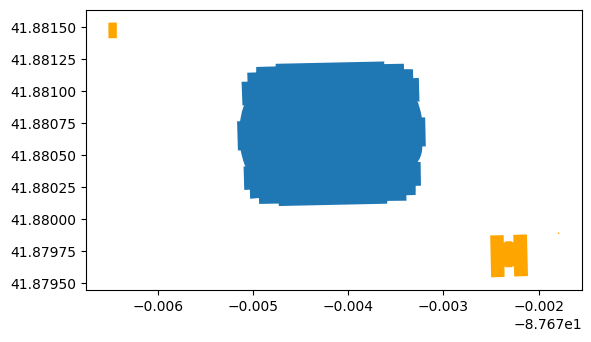

In [19]:
# # Verifying this is the right building
print(uc_candidates.bldg_name1)
ax = uc_candidates.iloc[0:1].plot()
uc_candidates.iloc[1:].plot(ax=ax,color='orange')

In [20]:
uc_building = uc_candidates[uc_candidates['bldg_name1'] == 'UNITED CENTER']

## McCormick Place

In [21]:
mp_xy = dms_to_decimal(*MCCORMICK_PLACE[1]), dms_to_decimal(*MCCORMICK_PLACE[0])
mp_xy = Point(*mp_xy) # lng/lat

In [22]:
mp_candidates = client.soda_get_all(BUILDINGS_TABLE, 
        where=f"within_circle(the_geom, {mp_xy.y}, {mp_xy.x}, 250)")
mp_candidates['geometry'] = mp_candidates['the_geom'].apply(shape)
mp_candidates = gpd.GeoDataFrame(mp_candidates, geometry='geometry', crs=WORLD_CRS)

0    HYATT REGENCY MCCORMICK PLACE
1                                 
Name: bldg_name1, dtype: object


<Axes: >

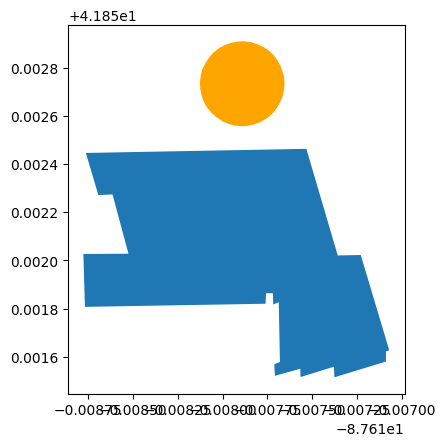

In [23]:
# # Verifying this is the right building
print(mp_candidates.bldg_name1)
ax = mp_candidates.iloc[0:1].plot()
mp_candidates.iloc[1:].plot(ax=ax,color='orange')

In [24]:
mp_building = mp_candidates[mp_candidates['bldg_name1'] == 'HYATT REGENCY MCCORMICK PLACE']

## POI Buildings

In [25]:
poi_buildings = pd.concat([mp_building, uc_building], ignore_index=True)
poi_buildings = poi_buildings.filter(['geometry','bldg_name1']).rename(columns={'bldg_name1':'name'})

# Pipeline out

In [26]:
poi_buildings.to_file(poi_file_out, index=False)